In [1]:
from gurobipy import *
import time
import pandas as pd
from scipy.spatial.distance import euclidean
import networkx as nx

In [2]:
path = 'customers.txt'
# read text file
with open(path, encoding='utf8') as f:
    lines = f.readlines()
    
rows = []
for line in lines:
    row = line.strip().split('\t')
    rows.append(row)
df = pd.DataFrame(rows, columns = rows[0])
df = df.drop(0)
df = df.set_index('CUST NO.')

first_row = df.iloc[0]
df = pd.concat([df, first_row.to_frame().transpose()], ignore_index=True)
df = df.astype({'X COORD.': 'int', 'Y COORD.': 'int'})
df.head()

,X COORD.,Y COORD.
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [9]:
Ndrones = 3 # Número de drones
k = Ndrones
n = len(df) - 2 # Número de clientes


N = range(1, len(df.index) - 1) # Índice de clientes {1, 2, ..., n}
V = range(len(df.index)) # Índice de clientes y depósito {0, 1, ..., n+1}
S = range(1,Ndrones + 1) # Índice de rutas inicales 


T = 40 # Time limit


# Se crean los arcos del grafo
arcos = []
for i in V:
    for j in V:
        if i != j:
            if i != len(V) - 1 and j != 0:
                arcos.append(tuple((i,j)))
arcos.remove((0, len(df) - 1))



# Se calculan los costos (distancias)

t = {} # Tiempo en minutos
for arc in arcos:
    point1 = df.loc[arc[0], ['X COORD.', 'Y COORD.']].values
    point2 = df.loc[arc[1], ['X COORD.', 'Y COORD.']].values
    distance = euclidean(point1, point2)
    t[arc] = distance
    
    

G = nx.DiGraph()
G.add_edges_from(arcos)

    
contador_s = 0
T_acum = 0
b_ijs = {}






b_ijs = {(i,j,s): 1 if (i == 0 and j == s) or (j == len(df)-1 and i == s) else 0 for (i,j) in arcos for s in S }

a_is = {(i,s): sum(b_ijs[i,j,s] for j in G.successors(i)) for i in G.nodes for s in S if i <= len(df)-2}

c_s = {s: sum(a_is[i,s] for i in N) for s in S}

### Greedy Best heuristic

In [10]:
def minimum_cost_arc(S_k, S):
    minimum = 10e6
    arc = 0
    for (i,j) in arcos:
        if i in S_k and j in N and j not in S:
            if t[i,j] < minimum:
                minimum = t[i,j]
                arc = tuple((i,j))
    return minimum, arc

In [16]:
S_k = {k: [0] for k in S} # Sets that will grow iteratively corresponding to each UAV to form the UAV's tour
S_heur = [0]
P_k = {k: [] for k in S} # Paths
R = [k for k in S]

while R:
    for k in R:

        cost, arc = minimum_cost_arc(S_k[k], S_heur)
        i_arc = arc[0]
        j_arc = arc[1]

        t_path = sum(t[i,j] for (i,j) in P_k[k])


        if t_path + t[0, j_arc] <= T:
            P_k[k].append(tuple(arc))
            S_k[k].append(j_arc)
            S_heur.append(j_arc)
            S_k[k].remove(i_arc) ###### LÍNEA QUE NO APARECE EN EL PSEUDO-CÓDIGO PERO ES ESENCIAL

        else:
            R.remove(k)
for k in S:
    last_node = P_k[k][-1][1]
    P_k[k].append(tuple((last_node, n+1)))

In [17]:
original_dict = P_k
new_dict = {}
for key, value in original_dict.items():
    new_value = []
    for arc in value:
        new_value.append([arc])
    new_dict[key] = new_value

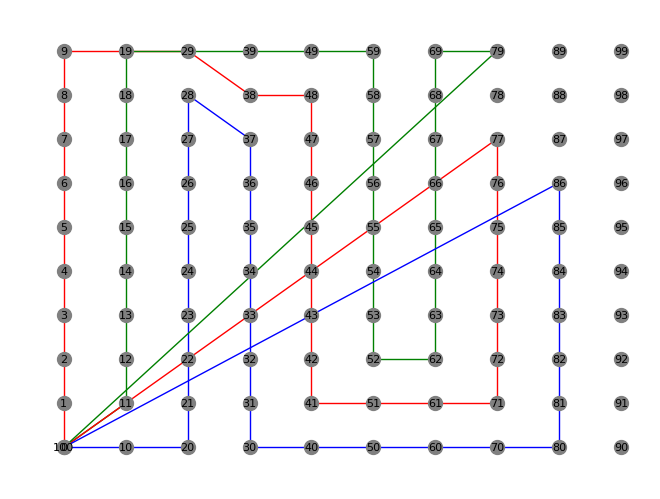

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# assume your dataframe is called 'df'
coord_dict = {idx: (row['X COORD.'], row['Y COORD.']) for idx, row in df.iterrows()}

# assume coord_dict is the dictionary of node coordinates
# assume routes_dict is the dictionary of routes

# create an empty graph
G = nx.Graph()

# add nodes to the graph using the coordinates from coord_dict
for idx, coords in coord_dict.items():
    G.add_node(idx, pos=coords)

# add edges to the graph using the routes in routes_dict
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink'] # define a list of colors for the routes
for idx, (route_id, route) in enumerate(new_dict.items()):
    for edge in route:
        G.add_edge(edge[0][0], edge[0][1], color=colors[idx]) # add the edge color for each route

# draw the graph using the node positions and edge colors
pos = nx.get_node_attributes(G, 'pos')
edge_colors = [G[u][v]['color'] for u,v in G.edges()] # set the edge colors based on the color attribute of each edge
nx.draw(G, pos, node_size=100, node_color='grey', with_labels=True, font_size=8, edge_color=edge_colors)

# show the plot
plt.show()